# First data exploration

### Extracting and cleaning plot summaries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

#Setting pandas display options
pd.set_option("max_colwidth", None)


from sentence_transformers import SentenceTransformer, util


#Src folder path
src_folder = 'src/data/'

In [2]:
df_plot_summaries = pd.read_csv(src_folder + 'plot_summaries.txt', sep='\t', header=None,  names=['id', 'summary'])
df_plot_summaries.sample(2)

id  \
26973  7643463   
30761   561315   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Some cleaning is necessary for the plot summaries. There appears to be in the data:

1) {{annotation}}
2) links (references to wikipedia)
3) <> html delimiters
4) ... further inspection needed

That need to be removed


In [3]:
def clean_plot(txt):

    #Remove URLs
    txt = re.sub(r"http\S+|www\.\S+", '', txt)

    #Remove HTML tags
    txt = re.sub(r'<.*?>', '', txt)

    #Remove {{annotations}}
    txt = re.sub(r'\{\{.*?\}\}', '', txt)

    #Remove the ([[ annotation that is never closed
    txt = re.sub(r'\(\[\[', '', txt)

    #Remove the synopsis from context
    txt = re.sub(r'Synopsis from', '', txt)

    #Remove <ref...}} tags
    txt = re.sub(r'<ref[^}]*}}', '', txt)

    return txt

In [4]:
df_test_clean = df_plot_summaries.copy()
df_test_clean["summary"] = df_plot_summaries['summary'].apply(clean_plot)
df_test_clean.sample(2)

,id,summary
12823,1025841,"The plot revolves around a series of couples in Monte Carlo, Monaco. Augie Morosco is a reformed gambler whose wife Elena Morosco (playing a similar character to her role in [[Oscar is concluding a business deal, Neil Schwary is a gambler looking to strike it big and whose wife Marilyn Schwary is hoping to buy some designer clothes. Julian Peters Richard Lewis and Phoebe met each other in Rome and are attempting to return a dachshund to the wealthy Madam Van Dougan. Madam Van Dougan is found murdered and the interactions between Julian and Phoebe and the other couples begin to look increasingly suspicious, as Inspector Bonnard needs to unravel the clues. Over the course of the film, Augie returns to gambling, Elena has an affair and Julian sells and repurchases the dog. The film is often described as having ""A chaotic screenplay, which results in everyone needing to shout at each other all the time"". The plot is fast-moving and often involves frantic wisecracking from all the principal characters. A memorable example is Julian being asked by Bonnard to ""look at this man's face"" . Julian takes one look at the strangely-featured man and screams. Later, Augie is requested to provide an alibi for the crime which took place ""Between one and one-thirty in the morning"". His alibi is that he was making love to his wife, and he can be certain because ""Her screams of pleasure woke up the street and someone cried out ... 'It's between one and one-thirty in the morning! Give that poor woman a break! Lewis' customary dry humour is ever-present, including his description of himself and Young as ""Julian Peters and Phoebe? We sound like a high-wire act!"" There are some elements of physical comedy, including the facial expressions of the characters as the contents of a suitcase are revealed. A striking example, however, is Augie's re-enactment of how he crept from room to room of a hotel at night."
14297,1252685,"Jimmy Alto is a failing actor living in Los Angeles. After increasing frustration with his career going nowhere and with crime in the city, Jimmy, along with his ""spaced-out"" best friend William , decides to take the law into his own hands. When he isn't working as a waiter, Jimmy transforms himself into ""Jericho,"" leader of a mock-vigilante group that videotapes criminals and then turns them over to the police. Jimmy enjoys the free publicity, anonymously, but eventually the police begin to close in on him, resulting in a tense standoff at the Grauman's Egyptian Theatre."


    histogram of the length of the summary

### check if we need to webscrap some summary from internet (if the summary is too short)

In [5]:
df_length_summary = df_test_clean['summary'].copy(deep=True)
df_length_summary = df_length_summary.apply(len) 


Text(0.5, 1.0, 'Distribution of the length of the summary')

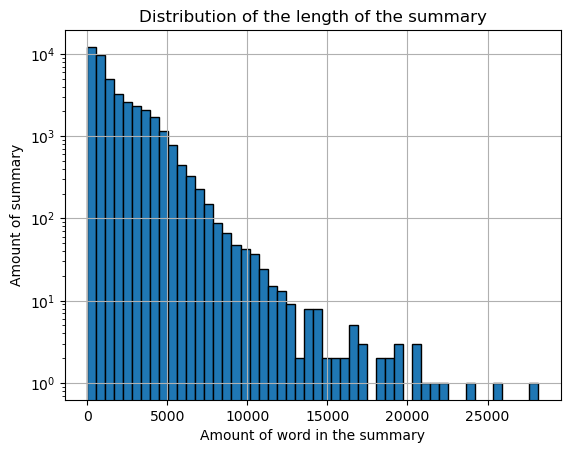

In [6]:
df_length_summary.hist(bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Amount of word in the summary')
plt.ylabel('Amount of summary')
plt.title('Distribution of the length of the summary')

Text(0.5, 1.0, 'Distribution of the summary that have length <= 200')

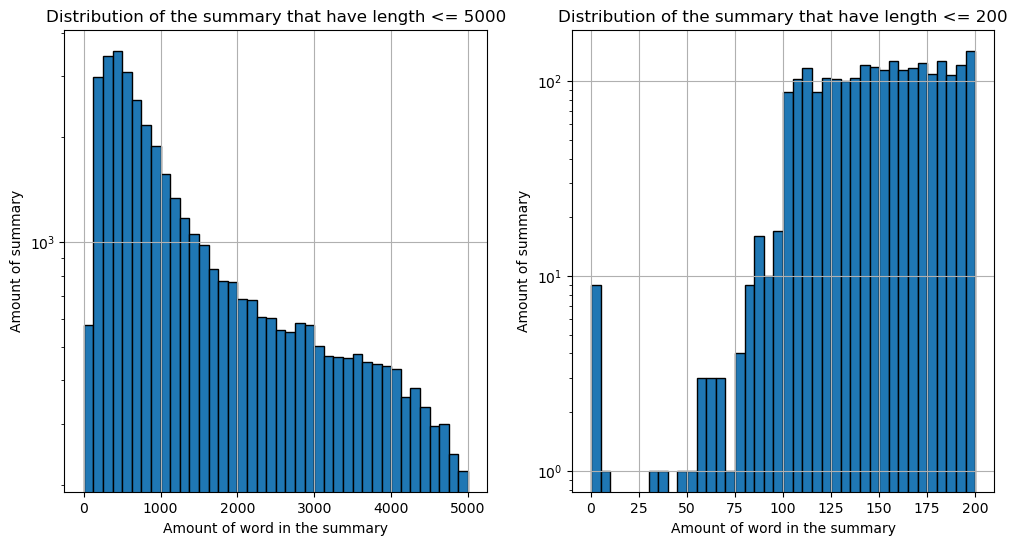

In [7]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.ravel()

df_length_summary_below_5000 = df_length_summary[df_length_summary <= 5000]
df_length_summary_below_5000.hist(bins=40, edgecolor='black', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Amount of word in the summary')
axes[0].set_ylabel('Amount of summary')
axes[0].set_title('Distribution of the summary that have length <= 5000')

thresh = 200
df_length_summary_below_1000 = df_length_summary[df_length_summary <= 200]
df_length_summary_below_1000.hist(bins=40, edgecolor='black', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('Amount of word in the summary')
axes[1].set_ylabel('Amount of summary')
axes[1].set_title(f'Distribution of the summary that have length <= {thresh}')

#### Sentiment analysis test

I see two possibilities: making classical sentiment analysis using twitter-roberta-base-sentiment trained on tweets or using distilbert-base-uncased-emotions for emotions

In [9]:
#First possibility: sentence by sentence sentiment classification

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)



dict_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        t_encoded = tokenizer(sentence, return_tensors='pt')
        t_output = model(**t_encoded)
        t_scores = softmax(t_output.logits.detach().numpy(), axis=1)
        t_predicted = np.argmax(t_scores)
        print(dict_labels[t_predicted], t_scores[0][t_predicted])
    

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Donovan also stars in the film, portraying a once-successful playwright, Robert Longfellow, who is taken hostage by an [ex-con] neighbor while on a routine visit to his childhood home.
neutral 0.9317461
Two-time Emmy-nominee David Morse plays Gus ; a man Robert has avoided since he was a boy.
positive 0.518725
The film also stars Olivia Williams; Katherine Helmond and Eileen Ryan play supporting roles.
neutral 0.82254916
As the drama unfolds, social status, celebrity and the threat of violence converge, leaving the playwright simultaneously shattered and inspired.
negative 0.6921979


In [10]:
# Second possibility: sentence to sentence emotion classification

#the emotions are anger, fear, joy, love, sadness, surprise and neutral

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        out = classifier(sentence)[0]
        best_emotion_dict = max(out, key=lambda x: x['score'])
        best_label = best_emotion_dict['label']
        best_score = best_emotion_dict['score']
        print(best_label, best_score)    

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In the late Third Age, Sauron's power is increasing, and he has sent his Orcs to seek out the remnants of the bloodline of Elendil, kept alive in the Dúnedain.
neutral 0.5457577705383301
Dirhael, his wife Ivorwen and their daughter Gilraen are fleeing from an attack on their village when they are ambushed by Orcs on a forest road, and saved by a group of rangers led by Arathorn.
fear 0.9862483143806458
Not having any place safer to go, the refugees go with Arathorn to Taurdal, the village led by his father and Chieftain of the Dúnedain, Arador.
fear 0.4790724813938141
While there, Arathorn and Arador ponder the Orcs' motives after finding various pieces of jewelry on their bodies.
neutral 0.6902116537094116
During her stay in Taurdal, Gilraen falls in love with Arathorn.
joy 0.7803062200546265
In light of the attacks on surrounding settlements, Arador leads his forces on a campaign against the Orcs in the area in an attempt to restore peace to the region.
anger 0.6179459691047668
Meanw

In [11]:
#keep small summary to test the segmentation
df_test_clean_with_length = df_test_clean.copy(deep=True)
df_test_clean_with_length['length'] = df_test_clean_with_length['summary'].apply(len) 
df_test_clean_with_length = df_test_clean_with_length[df_test_clean_with_length['length'] < 150]
df_test_clean_with_length.head(5)

,id,summary,length
39,28238240,"Mickey and the Scorpions decide to go on a big game hunt. The kids go out into the woods, only find themselves up against real wild animals .",141
55,27975390,"Reportedly, the film is about slum kids who are trained for a dance competition.Shaimak Davar in a director's avatar",116
116,33837735,"Emilio di Roccanera, The Black Corsair, seeks revenge against Governor Van Guld for the murder of his family.",109
184,27997130,Three young Russians from very different walks of life involutarily enter the military to escape their past.,108
198,9916623,"Butte Morgan plans to take over the circus my marrying Maria Wallace. She, however, is interested only in the trick rider Jack Grant.",134


In [12]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df_summary = df_test_clean_with_length['summary']
# Exemple de résumé (ce texte serait votre résumé complet de film)
summary = """
The story begins with the protagonist arriving in a new town. He feels out of place at first, but soon makes friends. 
As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest. 
This leads to a series of challenges that test his resolve. 
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.
"""

# 1. Diviser le résumé en phrases
sentences = summary.split(". ")
sentences = [s.strip() for s in sentences if s]  # Supprimer les espaces et les phrases vides

# 2. Obtenir les embeddings de chaque phrase
embeddings = model.encode(sentences)

# 3. Calculer les similarités cosinus entre phrases successives
similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]

# 4. Identifier les points de transition basés sur un seuil de similarité
threshold = 0.5  # Par exemple, une similarité inférieure à 0.5 indique un changement de thème
segments = []
current_segment = [sentences[0]]

for i, similarity in enumerate(similarities):
    if similarity < threshold:  # Si la similarité est faible, cela peut indiquer une transition
        segments.append(" ".join(current_segment))  # Ajouter le segment actuel à la liste
        current_segment = []  # Réinitialiser pour un nouveau segment
    current_segment.append(sentences[i + 1])

segments.append(" ".join(current_segment))  # Ajouter le dernier segment

# 5. Afficher les segments
for idx, segment in enumerate(segments):
    print(f"Segment {idx+1}:\n{segment}\n")

Segment 1:
The story begins with the protagonist arriving in a new town

Segment 2:
He feels out of place at first, but soon makes friends As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest

Segment 3:
This leads to a series of challenges that test his resolve

Segment 4:
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.



In [13]:
# Second possibility: sentence to sentence emotion classification

#the emotions are anger, fear, joy, love, sadness, surprise and neutral

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        out = classifier(sentence)[0]
        best_emotion_dict = max(out, key=lambda x: x['score'])
        best_label = best_emotion_dict['label']
        best_score = best_emotion_dict['score']
        print(best_label, best_score)    

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


The movie is about a kid named Luke Malloy  who wishes every day could be the last day of summer vacation.
neutral 0.6113730669021606
Soon after, he gets hit in the head and then wakes up during the same day again and again.
sadness 0.5338829159736633
To make it to tomorrow, he must dodge and overcome every obstacle that comes his way.
neutral 0.6520286798477173
The film begins with Luke preparing for a sleepover with his best friends, A.J.
neutral 0.7703849673271179
and Riley.
neutral 0.8040103316307068
The date is August 31, the second to last day of summer vacation.
neutral 0.5963679552078247
Luke and his pals are going into their first year of middle school and, if that weren't stressful enough, he has his older sister, Diana constantly worrying him with the dangers of junior high.
fear 0.7506008148193359
She warns him of the bully, Meat, who is a constant threat to incoming sixth graders.
fear 0.771891713142395
Luke waves it off and goes to his friend's house for a sleepover.
neut

In [14]:
#try to segment the text in a more clever way I guess?
from sentence_transformers import SentenceTransformer, util
nltk.download('punkt')  # Télécharge le tokenizer nécessaire pour les phrases

# Initialisation du modèle de classification d'émotions
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Initialisation du modèle de similarité de phrases
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Exemple de résumé (ou utilisez df_test_clean_with_length['summary'] pour appliquer à tout le dataset)
summary = """
The story begins with the protagonist arriving in a new town. He feels out of place at first, but soon makes friends. 
As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest. 
This leads to a series of challenges that test his resolve. 
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.
"""
#summary = df_summary_box_office.iloc[3]['summary']

# 1. Diviser le résumé en phrases
sentences = nltk.sent_tokenize(summary)  # Utiliser nltk pour la tokenisation des phrases
sentences = [s.strip() for s in sentences if s]  # Supprimer les espaces et les phrases vides

# 2. Obtenir les embeddings de chaque phrase
embeddings = model.encode(sentences)

# 3. Calculer les similarités cosinus entre phrases successives
similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]

# 4. Identifier les points de transition basés sur un seuil de similarité
threshold = 0.5  # Par exemple, une similarité inférieure à 0.5 indique un changement de thème
segments = []
current_segment = [sentences[0]]

for i, similarity in enumerate(similarities):
    if similarity < threshold:  # Si la similarité est faible, cela peut indiquer une transition
        segments.append(" ".join(current_segment))  # Ajouter le segment actuel à la liste
        current_segment = []  # Réinitialiser pour un nouveau segment
    current_segment.append(sentences[i + 1])

segments.append(" ".join(current_segment))  # Ajouter le dernier segment

# 5. Analyser les émotions de chaque segment et afficher les résultats
best_emotions = []
emotionsS = []
for idx, segment in enumerate(segments):
    print(f"Segment {idx+1}:\n{segment}\n")
    
    # Classifier les émotions pour chaque segment
    emotions = classifier(segment)[0]
    emotionsS.append(emotions)
    best_emotion = max(emotions, key=lambda x: x['score'])  # Sélectionner l'émotion avec le score le plus élevé
    best_emotions.append(best_emotion)
    # Afficher l'émotion dominante pour le segment
    print(f"Emotion dominante pour le Segment {idx+1}: {best_emotion['label']} : {best_emotion['score']:.2f}\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Segment 1:
The story begins with the protagonist arriving in a new town.

Emotion dominante pour le Segment 1: neutral : 0.62

Segment 2:
He feels out of place at first, but soon makes friends. As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest.

Emotion dominante pour le Segment 2: disgust : 0.68

Segment 3:
This leads to a series of challenges that test his resolve.

Emotion dominante pour le Segment 3: neutral : 0.83

Segment 4:
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.

Emotion dominante pour le Segment 4: neutral : 0.66



In [15]:
emotions = np.array([best_em['label'] for best_em in best_emotions])
scores = np.array([best_em['score'] for best_em in best_emotions])


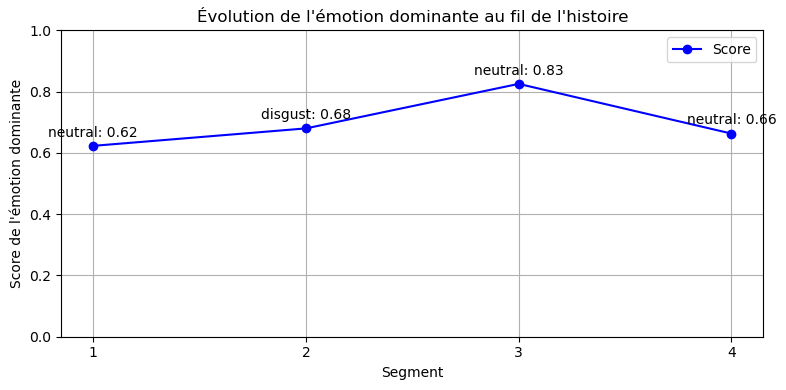

In [16]:

# Créer une liste de numéros de segment pour l'axe x
x = list(range(1, len(segments) + 1))

# Tracer les scores pour chaque segment
plt.figure(figsize=(8, 4))
plt.plot(x, scores, marker='o', linestyle='-', color='b', label='Score')

# Ajouter des annotations pour chaque point (émotion dominante)
for i, (emotion, score) in enumerate(zip(emotions, scores), start=1):
    plt.text(i, score + 0.02, f'{emotion}: {score:.2f}', ha='center', va='bottom')
# Configurer le graphique
plt.ylim(0, 1)
plt.xlabel('Segment')
plt.ylabel('Score de l\'émotion dominante')
plt.title('Évolution de l\'émotion dominante au fil de l\'histoire')
plt.xticks(x)  # Afficher les numéros de segment sur l'axe x
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


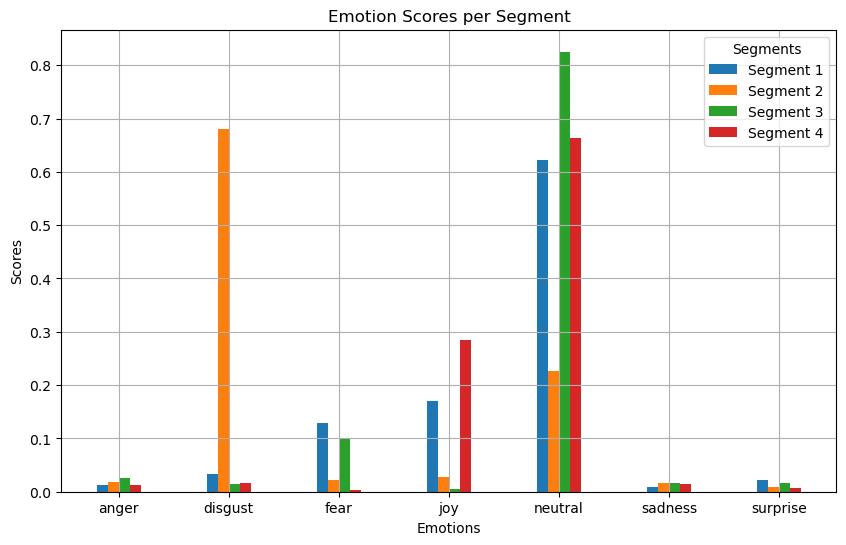

In [17]:

# Extract the list of emotions from the first segment
emotions = [entry['label'] for entry in emotionsS[0]]

# Extract scores for each emotion in each segment
scores = []
for segment in emotionsS:
    segment_scores = [entry['score'] for entry in segment]
    scores.append(segment_scores)

fig, ax = plt.subplots(figsize=(10, 6))

num_segments = len(emotionsS)
bar_width = 0.1

indices = np.arange(len(emotions))

for i in range(num_segments):
    ax.bar(indices + i * bar_width, scores[i], width=bar_width, label=f'Segment {i+1}')

# Set x-ticks in the middle of each group of bars
ax.set_xticks(indices + bar_width * (num_segments - 1) / 2)
ax.set_xticklabels(emotions)

# Add labels and title
ax.set_xlabel('Emotions')
ax.set_ylabel('Scores')
ax.set_title('Emotion Scores per Segment')
ax.legend(title='Segments')
plt.grid(True)

plt.show()


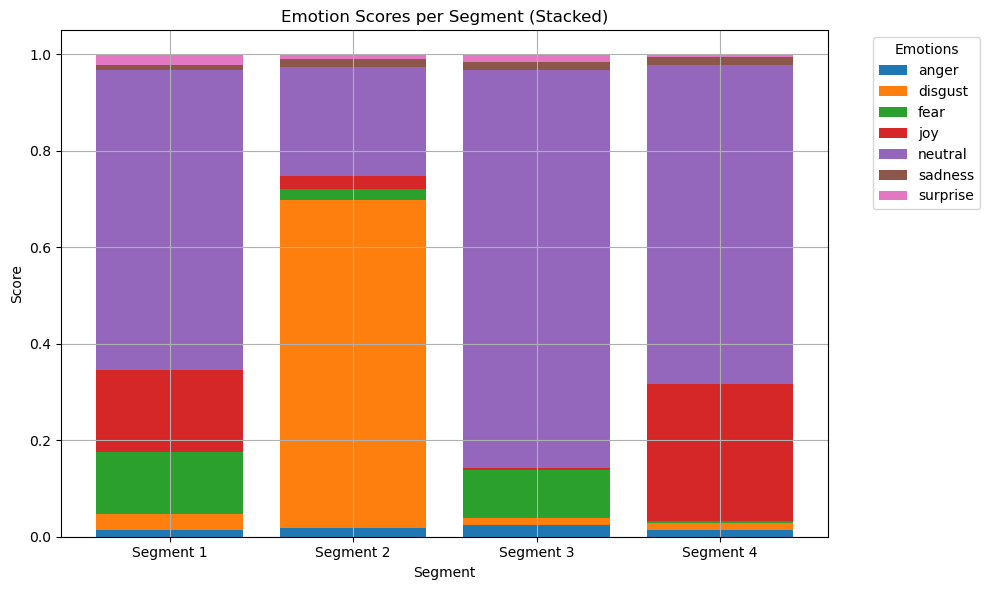

In [18]:
emotions = [entry['label'] for entry in emotionsS[0]]
scores_by_emotion = {emotion: [] for emotion in emotions}

for segment in emotionsS:
    for entry in segment:
        scores_by_emotion[entry['label']].append(entry['score'])

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(1, len(emotionsS) + 1)  # x positions for the bars (1, 2, 3, ...)

bottom = np.zeros(len(emotionsS))  # Initialize the bottom for stacking
for emotion in emotions:
    scores = scores_by_emotion[emotion]
    bars = ax.bar(x, scores, bottom=bottom, label=emotion)
    bottom += scores

ax.set_xlabel('Segment')
ax.set_ylabel('Score')
ax.set_title('Emotion Scores per Segment (Stacked)')
ax.set_xticks(x)
ax.set_xticklabels([f'Segment {i}' for i in x])
ax.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()

plt.show()


In [19]:
df_metadata = pd.read_csv(src_folder + 'movie.metadata.tsv', sep='\t', header=None,
                                    names=['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 
                                            'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime',
                                            'Movie_languages_(Freebase ID:name tuples)', 'Movie_countries_(Freebase ID:name tuples)',
                                           'Movie_genres_(Freebase ID:name tuples)'])

In [25]:
df_summary_box_office = pd.concat([df_test_clean[['id','summary']], df_metadata['Movie_box_office_revenue']], axis=1)
print(df_summary_box_office.shape)
df_summary_box_office.dropna(axis=0, inplace=True)
df_summary_box_office.shape

(81741, 3)


(4392, 3)

    Beaucoup de film n'ont pas de box office => bien de webscraper ça

In [175]:
src_save_emotion = 'df_emotion_per_movie'

In [134]:
#for every summary, compute its segment and every emotion for every segment, then store the result
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Define a function to process each summary into segments and get emotion scores
def process_summary(summary, threshold=0.5):
    # Split the summary into sentences
    sentences = nltk.sent_tokenize(summary)
    sentences = [s.strip() for s in sentences if s]  # Remove empty sentences
    
    # Get embeddings and calculate similarities
    embeddings = model.encode(sentences)
    similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
    
    # Split into segments based on similarity threshold
    segments = []
    current_segment = [sentences[0]]
    
    for i, similarity in enumerate(similarities):
        if similarity < threshold:
            segments.append(" ".join(current_segment))
            current_segment = []
        current_segment.append(sentences[i + 1])
    
    segments.append(" ".join(current_segment))  # Add the last segment

    # Get emotion scores for each segment
    segment_data = []
    for segment in segments:
        emotion_scores = {emotion['label']: emotion['score'] for emotion in classifier(segment)[0]}
        segment_data.append(emotion_scores)
    
    # Create DataFrame for this summary
    df_summary = pd.DataFrame(segment_data)
    return df_summary

# Assuming you have a main DataFrame df_summaries with a 'summary' column
# Process each summary and store the result as a dictionary of DataFrames
#summary_dfs = {}  # To store DataFrames for each summary
#df_summaries = df_summary_box_office.copy(deep=True)
df_summaries = df_test_clean.copy(deep=True)[:2000]
for _, row in tqdm(df_summaries.iterrows()):
    summary_text = row['summary']
    if not summary_text:
        continue
    df_summary = process_summary(summary_text)
    df_summary.name = row['id']
    path = src_save_emotion + f"/df_{df_summary.name}"
    df_summary.to_csv(path, index=False)
    #df_summary['box_office'] = row['Movie_box_office_revenue']
    #summary_dfs[idx] = df_summary  # Save the DataFrame by index or summary ID

# Display an example DataFrame for the first summary
#summary_dfs = list(summary_dfs.values())

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
6it [00:07,  1.18s/it]


KeyboardInterrupt: 

A partir de ça, essayer de faire une regression linéaire avec ces valeurs et le box office?

In [135]:
import glob
import os

def load_dfs(folder_path,):

    file_paths = glob.glob(os.path.join(folder_path, '*')) 

    dataframes = []
    for file_path in tqdm(file_paths):
        #looks for id which should be at the end of the file
        match = re.search(r'df_(\d+)', file_path)
        name = int(match.group(1))
        df = pd.read_csv(file_path) 
        df.name = name
        dataframes.append(df)
    return dataframes
dfs = load_dfs(src_save_emotion)

100%|█████████████████████████████████████████████████████████████████████████████| 1999/1999 [00:02<00:00, 955.72it/s]


In [257]:
src_save_emotion = "df_genre_and_emotions_per_movie"

In [258]:
def clean_genre(movie_genre):
    cleaned_text = re.findall(r': "([^"]+)"', movie_genre)
    return cleaned_text
def map_id_to_genre(df):
    id_ = df.name
    idx_movie = np.where(df_metadata['Wikipedia_movie_ID'] == id_)[0]
    if len(idx_movie) == 0:
        return []
    movie_genre = df_metadata['Movie_genres_(Freebase ID:name tuples)'].iloc[idx_movie].iloc[0]
    movie_genre_cleaned = clean_genre(movie_genre)
    return movie_genre_cleaned

In [259]:
#on prend chaque df, et on le duplicate autant de fois qu'il y a de genre associé à son film
new_dfs = []
features = list(dfs[0].columns)
features.append('genre')
genres = []
for idx, df in tqdm(enumerate(dfs)):
    movie_genre = map_id_to_genre(df)
    if len(movie_genre) == 0:
        continue
    df_result = pd.DataFrame()
    for genre in movie_genre:
        genre = genre.replace("/", "_").replace(" ", "_").replace("-", "_").replace("'", "_").replace("[", "_").replace("]", "_")
        df_result = df.copy(deep=True)
        df_result['genre'] = genre
        genres.append(genre)
        #df_result = pd.concat([df_result, df_concat], axis=0)
        #df_result = pd.get_dummies(df_result[features])
        df_result.name = df.name
        new_dfs.append(df_result)

1999it [00:02, 836.86it/s] 


In [260]:
#save every df with emotion with the genre of its film + keep every different genre we encounter
genres = []
for df in tqdm(new_dfs):
    genre = df['genre'].iloc[0]
    genres.append(genre)
    path = src_save_emotion + f"/df_{df.name}_{genre}"
    df.to_csv(path, index=False)
    

100%|█████████████████████████████████████████████████████████████████████████████| 7103/7103 [00:30<00:00, 231.18it/s]


In [269]:
#get the counts of every different genre, and keep the one that are present more than n times
unique_genre, counts_genre = np.unique(genres, return_counts = True)
idx_genre_with_enough_film = np.where(counts_genre >= 20)
unique_genre = unique_genre[idx_genre_with_enough_film]
len(unique_genre)

59

In [277]:
#load les df que pour les genres qui ont assez de film
import glob
import os

def load_dfs_from_genre(folder_path):

    file_paths = glob.glob(os.path.join(folder_path, '*')) 

    dataframes = []
    for file_path in tqdm(file_paths):
        match = re.search(r'_(\D\w+)$', file_path)
        name = match.group(1)
        if name not in unique_genre:
            continue
        df = pd.read_csv(file_path) 
        df.name = name
        dataframes.append(df)
    return dataframes
dfs_with_genre = load_dfs_from_genre(src_save_emotion)

100%|████████████████████████████████████████████████████████████████████████████| 7102/7102 [00:06<00:00, 1038.50it/s]


In [280]:
#mtn faut faire les calcules par genre
dfs_with_genre

[      anger   disgust      fear       joy   neutral   sadness  surprise  \
 0  0.012047  0.020838  0.005157  0.041063  0.852842  0.021021  0.047033   
 1  0.001860  0.011338  0.004301  0.016489  0.113932  0.845161  0.006919   
 
         genre  
 0  Short_Film  
 1  Short_Film  ,
        anger   disgust      fear       joy   neutral   sadness  surprise  \
 0   0.154801  0.008810  0.611418  0.016647  0.009420  0.185482  0.013423   
 1   0.003154  0.002395  0.987093  0.000678  0.001556  0.002723  0.002401   
 2   0.981971  0.005157  0.000927  0.000424  0.003813  0.005666  0.002042   
 3   0.127852  0.005487  0.840319  0.001177  0.013955  0.006701  0.004508   
 4   0.956873  0.024271  0.001955  0.000459  0.010001  0.004542  0.001899   
 5   0.048719  0.034874  0.002952  0.016270  0.801957  0.088545  0.006683   
 6   0.068863  0.189540  0.015983  0.167846  0.497271  0.043605  0.016892   
 7   0.039989  0.465640  0.023224  0.335351  0.111068  0.010386  0.014342   
 8   0.023230  0.027489  

In [265]:
glob.glob(os.path.join(src_save_emotion, '*'))[647:650]

['df_genre_and_emotions_per_movie\\df_12576808_Science_Fiction',
 'df_genre_and_emotions_per_movie\\df_12594210_Biographical_film',
 'df_genre_and_emotions_per_movie\\df_12594210_Biopic__feature_']